In [ ]:
import cv2
import numpy as np
import os

# Define input/output folders for images
input_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Raw_image"
output_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\segmented_1201_copy2"
individual_squares_folder = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\bounding_boxes"

# Create output folders if they don't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if not os.path.exists(individual_squares_folder):
    os.makedirs(individual_squares_folder)

def single_scale_retinex(img, sigma):
    # Apply single-scale Retinex to enhance image contrast
    blur = cv2.GaussianBlur(img, (0, 0), sigma)
    retinex = np.log1p(img) - np.log1p(blur)
    return retinex

def multi_scale_retinex(img, sigmas=[15, 80, 250]):
    # Apply multi-scale Retinex to enhance image contrast using different sigma values
    retinex = np.zeros_like(img, dtype=np.float32)
    for sigma in sigmas:
        retinex += single_scale_retinex(img, sigma)
    retinex = retinex / len(sigmas)
    return retinex

def fill_mask(gray_img):
    # Fill small holes in the binary mask to improve segmentation
    fill_mask = cv2.morphologyEx(gray_img, cv2.MORPH_CLOSE, kernel=np.ones((3, 3), np.uint8))
    return fill_mask

def apply_clahe(img):
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance contrast
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def check_aspect_ratio_angle_and_area(component_mask, min_area=7000, max_area=13000):
    # Check if the component has a valid aspect ratio, angle, and area
    x, y, w, h = cv2.boundingRect(component_mask)
    aspect_ratio = w / float(h)
    if not (0.8 < aspect_ratio < 1.2):
        return False
    area = w * h
    if not (min_area <= area <= max_area):
        return False
    return True

def find_connected_components(img, original_img, filename):
    # Find connected components (objects) in the image and apply bounding boxes to them
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filled_img = fill_mask(gray)
    sharpened_img = sharpen_image(filled_img)  # Assuming sharpen_image function is defined elsewhere
    blurred = cv2.GaussianBlur(sharpened_img, (5, 5), 70)
    sharpened_img = sharpen_image(blurred)
    edges = cv2.Canny(sharpened_img, 135, 220)
    dilated = cv2.dilate(edges, None, iterations=2)
    num_labels, labels = cv2.connectedComponents(dilated)
    output_img = cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR)
    square_count = 0

    for label in range(1, num_labels):
        # Iterate over each connected component and check for valid squares
        component_mask = np.zeros_like(gray)
        component_mask[labels == label] = 255
        if check_aspect_ratio_angle_and_area(component_mask):
            x, y, w, h = cv2.boundingRect(component_mask)
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 1)

            # Extract and save the detected square
            square_img = original_img[y:y + h, x:x + w]
            square_filename = f"{os.path.splitext(filename)[0]}_square_{square_count + 1}.png"
            square_path = os.path.join(individual_squares_folder, square_filename)
            cv2.imwrite(square_path, square_img)

            square_count += 1

    return output_img, square_count

def process_dataset(input_folder, output_folder):
    # Process all images in the input folder
    total_squares = 0  # Initialize total square count
    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found: {filename}")
            continue
        original_img = img.copy()
        img = img.astype(np.float32) / 255.0
        clahe_result = apply_clahe((img * 255).astype(np.uint8))
        msr_result = multi_scale_retinex(img)
        msr_result = cv2.normalize(msr_result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        combined_result = cv2.addWeighted(clahe_result, 0.7, msr_result, 0.3, 0)
        gaussian_result = cv2.GaussianBlur(combined_result, ksize=(5, 5), sigmaX=0.5)
        segmented_img, square_count = find_connected_components(gaussian_result, original_img, filename)
        total_squares += square_count  # Add the square count for this image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, segmented_img)
        print(f"Processed {filename}: Detected {square_count} squares.")

    # Print the total square count
    print(f"Total squares detected across all images: {total_squares}")

# Run the dataset processing
process_dataset(input_folder, output_folder)


Processed NakedTop01.jpg: Detected 17 squares.
Processed NakedTop02.jpg: Detected 24 squares.
Processed NakedTop03.jpg: Detected 22 squares.
Processed NakedTop04.jpg: Detected 22 squares.
Processed NakedTop05.jpg: Detected 22 squares.
Processed NakedTop06.jpg: Detected 25 squares.
Processed NakedTop07.jpg: Detected 27 squares.
Processed NakedTop08.jpg: Detected 27 squares.
Processed NakedTop09.jpg: Detected 26 squares.
Processed NakedTop10.jpg: Detected 27 squares.
Processed NakedTop11.jpg: Detected 25 squares.
Processed NakedTop12.jpg: Detected 22 squares.
Processed NakedTop13.jpg: Detected 26 squares.
Processed NakedTop14.jpg: Detected 24 squares.
Processed NakedTop15.jpg: Detected 27 squares.
Processed NakedTop16.jpg: Detected 27 squares.
Processed NakedTop17.jpg: Detected 23 squares.
Processed NakedTop18.jpg: Detected 27 squares.
Processed NakedTop19.jpg: Detected 27 squares.
Processed NakedTop20.jpg: Detected 26 squares.
Total squares detected across all images: 493


Mean IoU for NakedTop01.jpg: 0.598269474505216


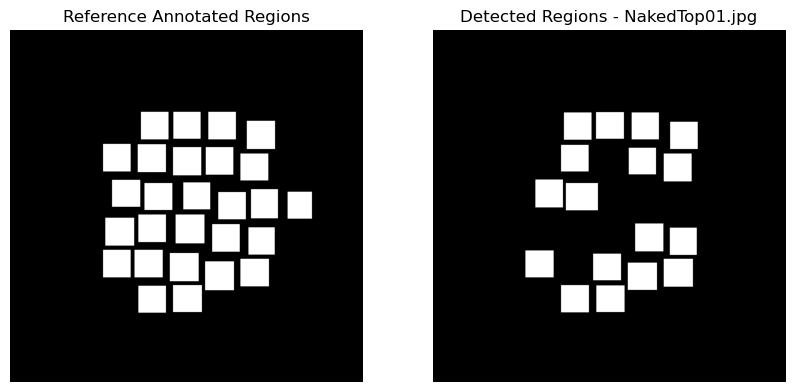

Mean IoU for NakedTop02.jpg: 0.8057558615521955


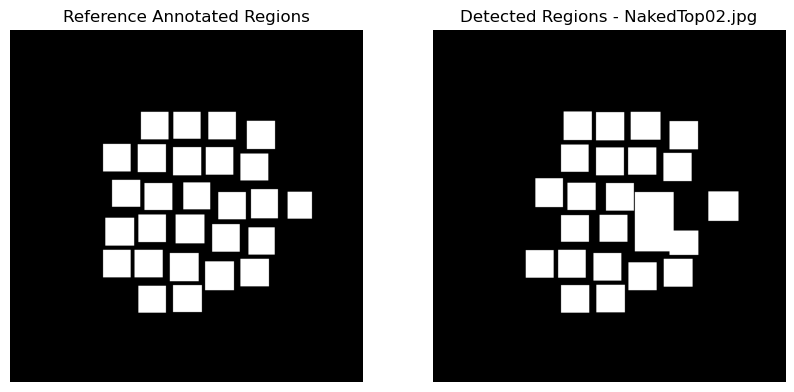

Mean IoU for NakedTop03.jpg: 0.7163408913213448


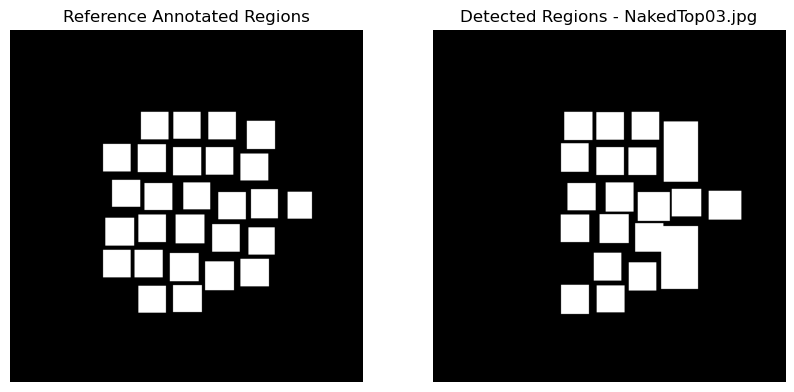

Mean IoU for NakedTop04.jpg: 0.7085417180290917


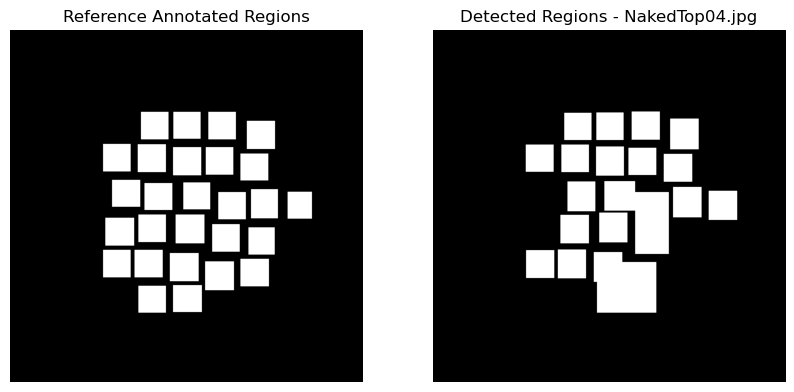

Mean IoU for NakedTop05.jpg: 0.6992263378602572


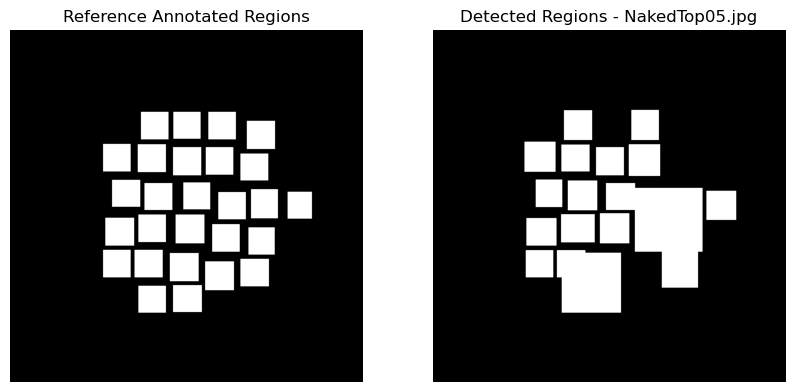

Mean IoU for NakedTop06.jpg: 0.8166932889378838


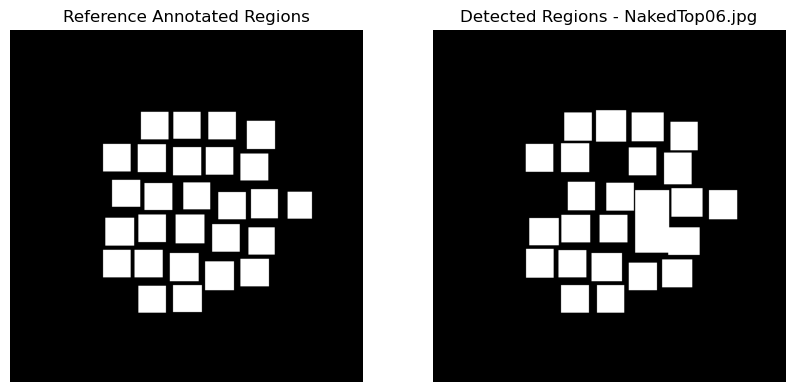

Mean IoU for NakedTop07.jpg: 0.8120674501788452


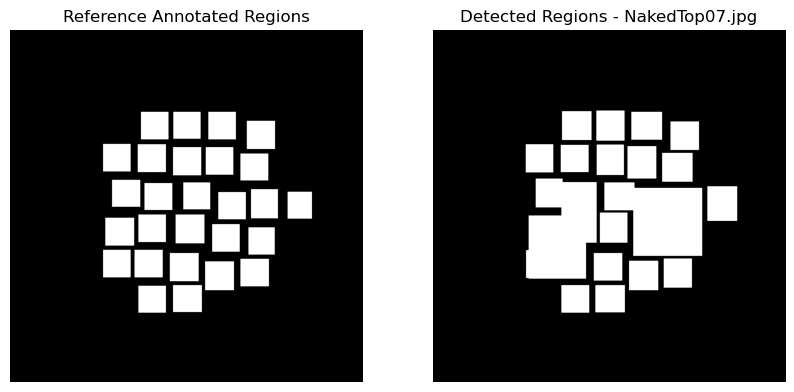

Mean IoU for NakedTop08.jpg: 0.8933800960531543


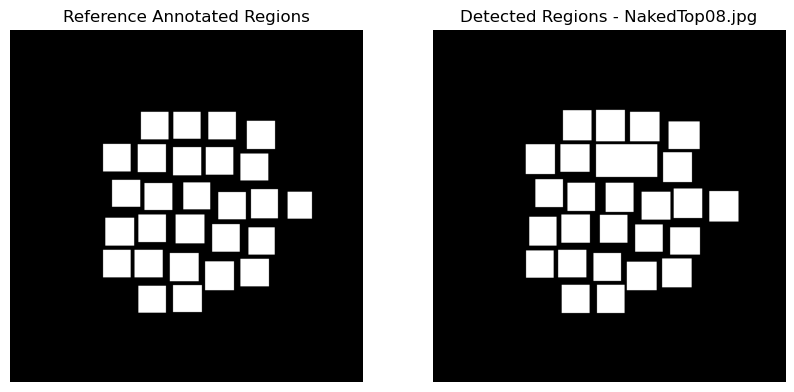

Mean IoU for NakedTop09.jpg: 0.7751168556680079


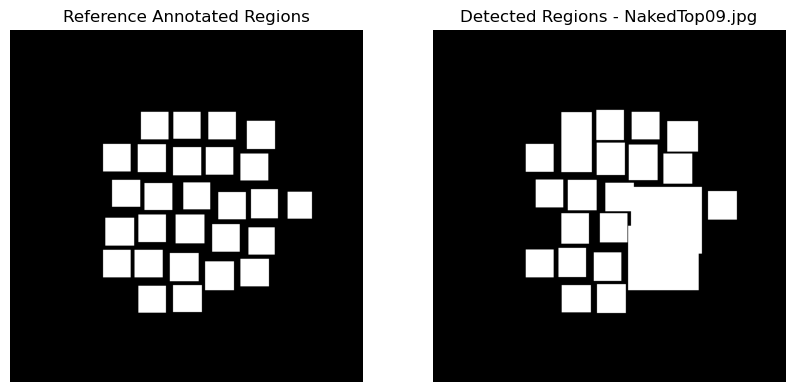

Mean IoU for NakedTop10.jpg: 0.88195072585773


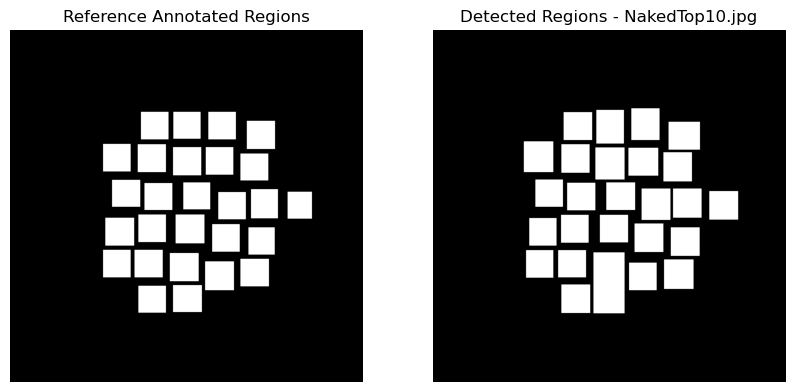

Mean IoU for NakedTop11.jpg: 0.7833448115084033


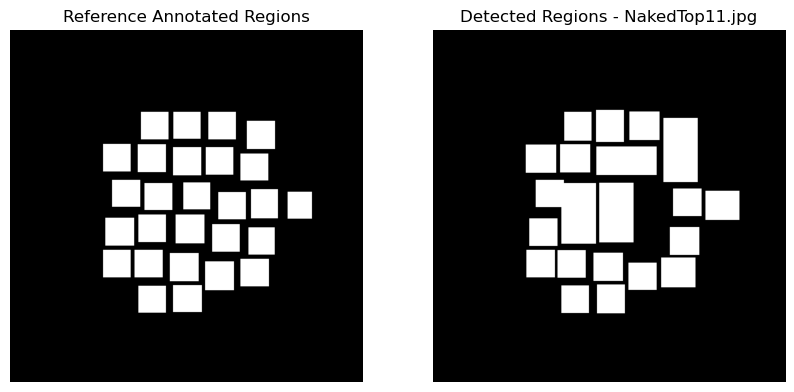

Mean IoU for NakedTop12.jpg: 0.6874129481557906


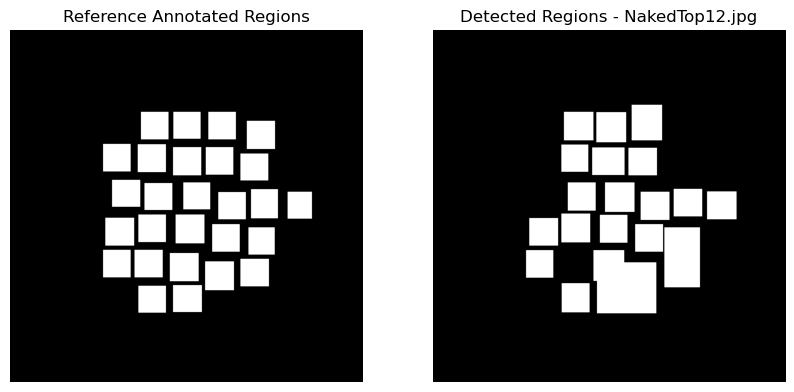

Mean IoU for NakedTop13.jpg: 0.8095779001418824


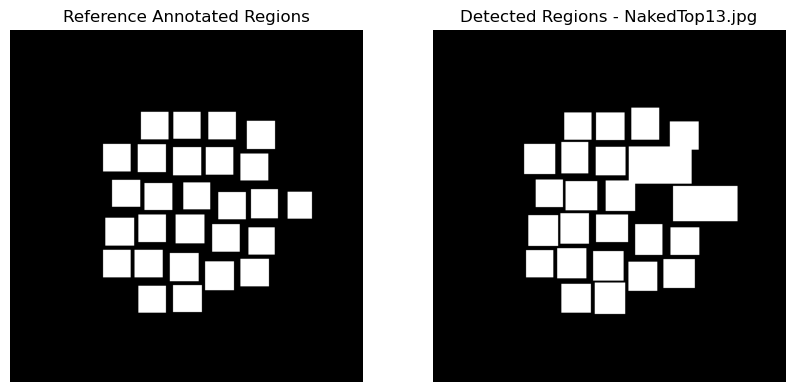

Mean IoU for NakedTop14.jpg: 0.7948940029475117


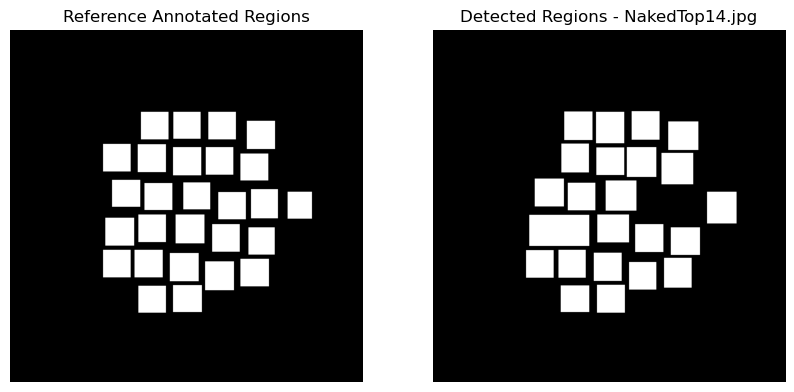

Mean IoU for NakedTop15.jpg: 0.8587796047341496


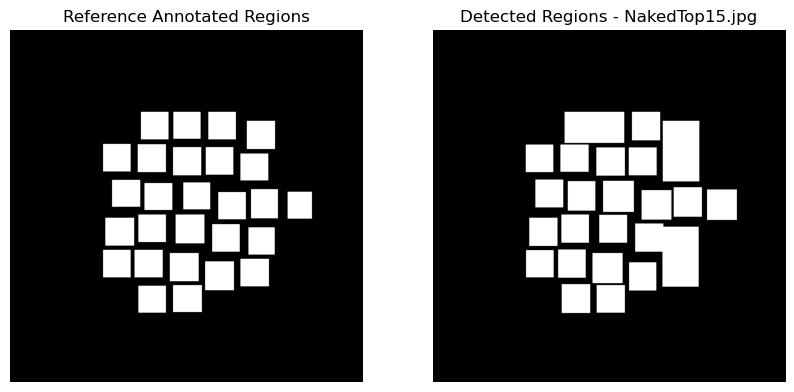

Mean IoU for NakedTop16.jpg: 0.868120879607097


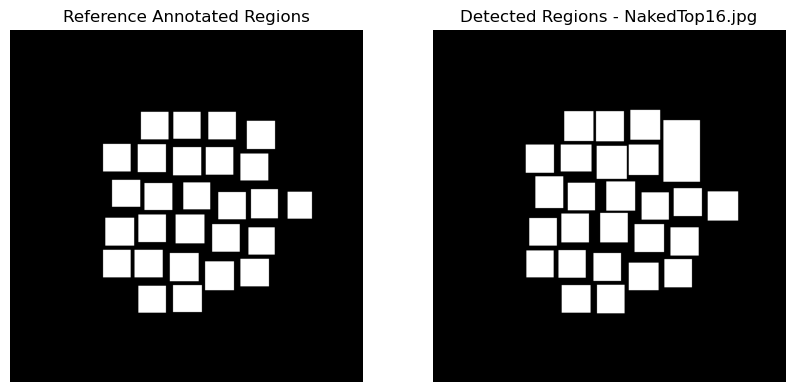

Mean IoU for NakedTop17.jpg: 0.7014814445745414


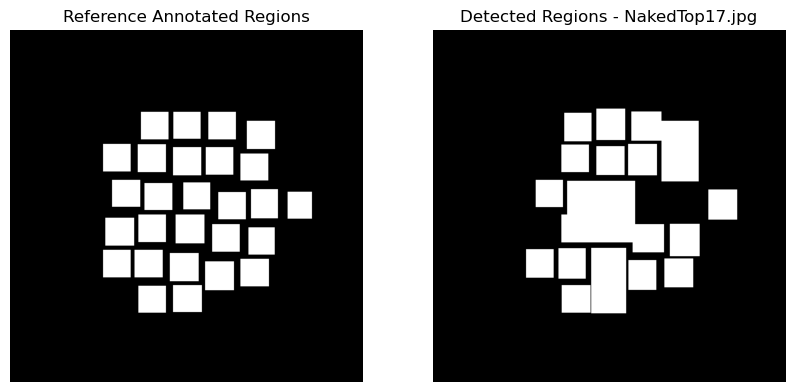

Mean IoU for NakedTop18.jpg: 0.8559448056439342


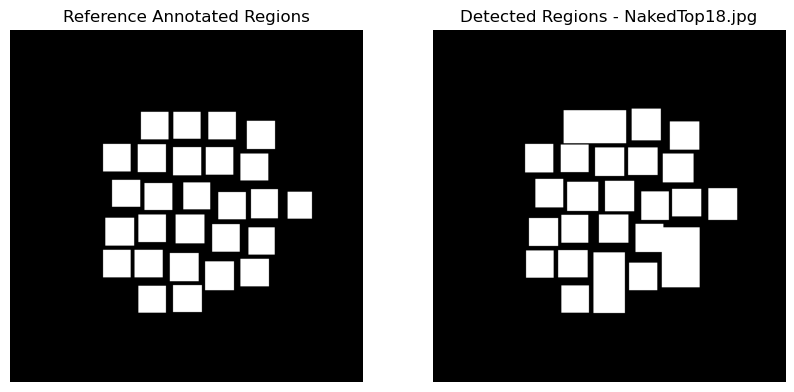

Mean IoU for NakedTop19.jpg: 0.8341206079202794


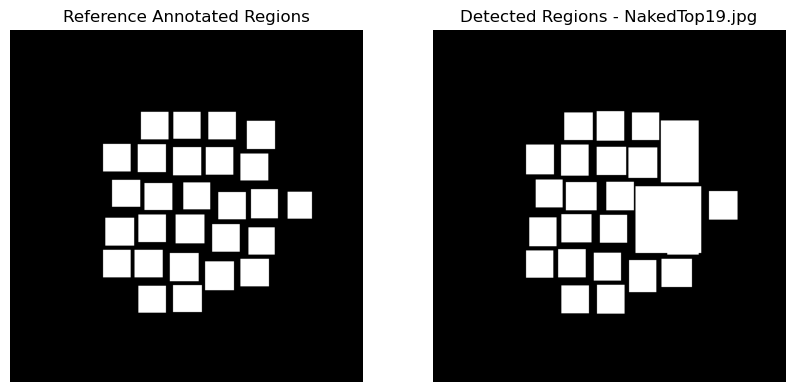

Mean IoU for NakedTop20.jpg: 0.855312103168371


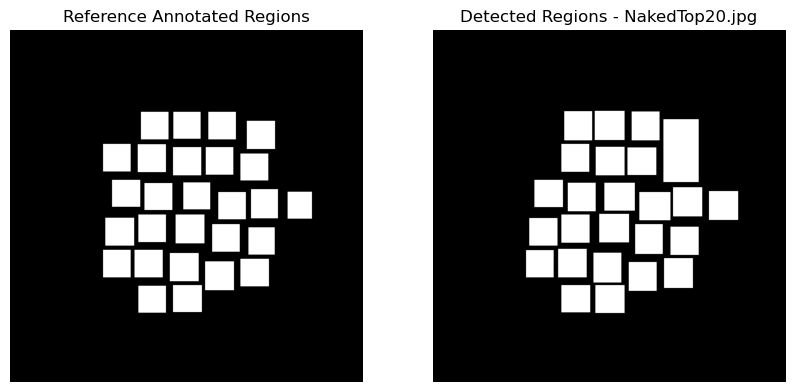

Overall Mean IoU for all images: 0.7878165904182844


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths for the segmented images and annotated images
detected_images = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\segmented_1201_copy2"
annotated_images = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\ann"

def calculate_combined_miou(annotated_bboxes, detected_bboxes, image_shape):
    # Calculate the Mean Intersection over Union (IoU) for the annotated and detected bounding boxes
    annotated_mask = np.zeros(image_shape, dtype=np.uint8)  # Create an empty mask for annotated bounding boxes
    detected_mask = np.zeros(image_shape, dtype=np.uint8)  # Create an empty mask for detected bounding boxes

    # Fill the annotated mask
    for (x, y, w, h) in annotated_bboxes:
        annotated_mask[y+1:y+h-1, x+1:x+w-1] = 1

    # Fill the detected mask
    for (x, y, w, h) in detected_bboxes:
        detected_mask[y+2:y+h-2, x+2:x+w-2] = 1

    # Compute intersection and union between annotated and detected masks
    intersection = np.logical_and(annotated_mask, detected_mask).sum()
    union = np.logical_or(annotated_mask, detected_mask).sum()

    # Calculate IoU
    miou = intersection / union if union != 0 else 1
    return miou, annotated_mask, detected_mask

def find_bounding_boxes(image, color_range):
    # Find bounding boxes based on color range in the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert the image to HSV color space
    mask = cv2.inRange(hsv, color_range[0], color_range[1])  # Create a mask based on color range
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    return [cv2.boundingRect(contour) for contour in contours]  # Return bounding boxes for each contour

def display_masks(annotated_mask, detected_mask, filename):
    # Displaying the annotated and detected masks side by side for comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Annotated mask
    axes[0].imshow(annotated_mask, cmap='gray')
    axes[0].set_title("Reference Annotated Regions")
    axes[0].axis('off')

    # Detected mask
    axes[1].imshow(detected_mask, cmap='gray')
    axes[1].set_title(f"Detected Regions - {filename}")
    axes[1].axis('off')

    plt.show()

def calculate_miou_for_all_images(detected_images_folder, annotated_image_path):
    # Calculate Mean IoU for all images in the detected images folder
    results = {}
    miou_values = []
    green_color_range = (np.array([35, 50, 50]), np.array([85, 255, 255]))  # Define the color range for green

    # Load the annotated reference image
    annotated_image = cv2.imread(annotated_image_path)
    if annotated_image is None:
        print("Error loading the annotated image.")
        return results

    image_shape = annotated_image.shape[:2]
    annotated_bboxes = find_bounding_boxes(annotated_image, green_color_range)

    # Process each detected image
    for filename in os.listdir(detected_images_folder):
        detected_image_path = os.path.join(detected_images_folder, filename)

        detected_image = cv2.imread(detected_image_path)
        if detected_image is None:
            print(f"Error loading detec


In [ ]:
import pandas as pd
miou_df = pd.DataFrame(list(miou_results.items()), columns=["Image", "mIoU"])

print("\nMean IoU for all images:")
miou_df


Mean IoU for all images:


,Image,mIoU
0,NakedTop01.jpg,0.598269
1,NakedTop02.jpg,0.805756
2,NakedTop03.jpg,0.716341
3,NakedTop04.jpg,0.708542
4,NakedTop05.jpg,0.699226
5,NakedTop06.jpg,0.816693
6,NakedTop07.jpg,0.812067
7,NakedTop08.jpg,0.893380
8,NakedTop09.jpg,0.775117
9,NakedTop10.jpg,0.881951


In [ ]:
print(f"Overall Mean IoU: {overall_mean_miou}")

Overall Mean IoU: 0.7878165904182844


In [ ]:
import os
from PIL import Image
import numpy as np


dataset_path = r"C:\Users\keert\OneDrive\Desktop\Feature Engg\Project\IO_Images\Prep\bounding_boxes"

images = []
labels = []

image_size = (100, 100)


for label in ['good', 'bad']:
    folder_path = os.path.join(dataset_path, label)

    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)

            image = Image.open(img_path).convert('L')

            image = image.resize(image_size)

            image_array = np.array(image)

            images.append(image_array)
            labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [ ]:
images.shape

(493, 100, 100)

In [ ]:
labels.shape

(493,)

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: bad, Count: 317
Label: good, Count: 176


In [ ]:
import random
from PIL import Image, ImageEnhance
import numpy as np

image_size = (100, 100)

def augment_image(image):
    # Random rotation
    image = image.rotate(random.choice([0, 90, 180, 270]))

    # Random brightness adjustment
    if random.random() < 0.5:
        enhancer = ImageEnhance.Brightness(image)
        factor = random.uniform(0.5, 1.5)
        image = enhancer.enhance(factor)

    # Random contrast adjustment
    if random.random() < 0.5:
        enhancer = ImageEnhance.Contrast(image)
        factor = random.uniform(0.5, 1.5)
        image = enhancer.enhance(factor)

    # Resize to target size
    image = image.resize(image_size)

    return image

# Apply additional augmentation
augmented_images = list(images)
augmented_labels = list(labels)

# Create a class balance
unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = max(label_counts)  # Find the class with the maximum count

# Augment images to balance the classes
for idx, img_array in enumerate(images):
    image = Image.fromarray(img_array)
    label = labels[idx]

    if random.random() < 0.9:  # Apply augmentation with a 90% chance
        augmented_image = augment_image(image)
        augmented_images.append(np.array(augmented_image))
        augmented_labels.append(label)

    # Balance class sizes by duplicating images from underrepresented classes
    current_class_count = sum(1 for lbl in augmented_labels if lbl == label)
    if current_class_count < max_count:
        while current_class_count < max_count:
            augmented_image = augment_image(image)
            augmented_images.append(np.array(augmented_image))
            augmented_labels.append(label)
            current_class_count += 1

# Convert lists back to arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Display the counts for each class after balancing
unique_labels, label_counts = np.unique(augmented_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: bad, Count: 603
Label: good, Count: 481


In [ ]:
augmented_images.shape

(1084, 100, 100)

In [ ]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def extract_lbp_features(image, P=8, R=1):

    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)

    return lbp, hist

lbp_features = []
for image in augmented_images:
    _, lbp_feature = extract_lbp_features(image)
    lbp_features.append(lbp_feature)

X = np.array(lbp_features)

y = np.array([1 if label == 'good' else 0 for label in augmented_labels])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
best_params = None

for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()

best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

y_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on validation set: {final_accuracy:.4f}")


Best model's accuracy from cross-validation: 0.8439
Final model's accuracy on validation set: 0.8664


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[111   6]
 [ 23  77]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       117
           1       0.93      0.77      0.84       100

    accuracy                           0.87       217
   macro avg       0.88      0.86      0.86       217
weighted avg       0.87      0.87      0.86       217



In [ ]:
X.shape

(1084, 10)

In [ ]:
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to extract HOG features
def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    # Ensure the image has the correct shape for HOG
    if len(image.shape) > 2:
        image = image[:, :, 0]
    hog_features = hog(image, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       orientations=orientations, block_norm='L2-Hys')
    return hog_features

# Extract HOG features for all images
hog_features = []
for image in augmented_images:
    hog_feature = extract_hog_features(image)
    hog_features.append(hog_feature)

X = np.array(hog_features)
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train an SVM with cross-validation
svm = SVC(kernel='linear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
best_params = None

for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()

# Evaluate the best model on the test set
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on test set: {final_accuracy:.4f}")


Best model's accuracy from cross-validation: 0.7514
Final model's accuracy on test set: 0.7465


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[95 22]
 [33 67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.78       117
           1       0.75      0.67      0.71       100

    accuracy                           0.75       217
   macro avg       0.75      0.74      0.74       217
weighted avg       0.75      0.75      0.74       217



In [ ]:
X.shape

(1084, 4356)

In [ ]:
import numpy as np
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to extract HOG features
def extract_hog_features(image, pixels_per_cell=(4, 4), cells_per_block=(3, 3), orientations=6):
    # Ensure the image has the correct shape for HOG
    if len(image.shape) > 2:
        image = image[:, :, 0]
    hog_features = hog(image, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       orientations=orientations, block_norm='L2-Hys')
    return hog_features

# Extract HOG features for all images
hog_features = []
for image in augmented_images:
    hog_feature = extract_hog_features(image)
    hog_features.append(hog_feature)

X = np.array(hog_features)
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train an SVM with cross-validation
svm = SVC(kernel='linear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
best_params = None

for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()

# Evaluate the best model on the test set
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Explained variance by PCA: {sum(pca.explained_variance_ratio_):.4f}")
print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on test set: {final_accuracy:.4f}")

Explained variance by PCA: 0.4012
Best model's accuracy from cross-validation: 0.7919
Final model's accuracy on test set: 0.8295


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[105  12]
 [ 25  75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       117
           1       0.86      0.75      0.80       100

    accuracy                           0.83       217
   macro avg       0.83      0.82      0.83       217
weighted avg       0.83      0.83      0.83       217



In [ ]:
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to extract LBP features
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

# Function to extract HOG features
def extract_hog_features(image, pixels_per_cell=(4, 4), cells_per_block=(3, 3), orientations=6):
    # Ensure the image has the correct shape for HOG
    if len(image.shape) > 2:
        image = image[:, :, 0]
    hog_features = hog(image, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       orientations=orientations, block_norm='L2-Hys')
    return hog_features

# Extract LBP and HOG features
lbp_features = []
hog_features = []
for image in augmented_images:
    lbp_feature = extract_lbp_features(image)
    hog_feature = extract_hog_features(image)
    lbp_features.append(lbp_feature)
    hog_features.append(hog_feature)

# Convert features to arrays
X_lbp = np.array(lbp_features)
X_hog = np.array(hog_features)
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])

# Standardize the HOG features only
scaler_hog = StandardScaler()
X_hog_scaled = scaler_hog.fit_transform(X_hog)

# Apply PCA to HOG features
pca = PCA(n_components=50, random_state=42)
X_hog_pca = pca.fit_transform(X_hog_scaled)

# Combine LBP and reduced HOG features
X_combined = np.hstack((X_lbp, X_hog_pca))

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train an SVM with cross-validation
svm = SVC(kernel='linear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
best_params = None

for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()

# Evaluate the best model on the test set
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Explained variance by PCA on HOG: {sum(pca.explained_variance_ratio_):.4f}")
print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on test set: {final_accuracy:.4f}")


Explained variance by PCA on HOG: 0.2992
Best model's accuracy from cross-validation: 0.7931
Final model's accuracy on test set: 0.8618


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[109   8]
 [ 22  78]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       117
           1       0.91      0.78      0.84       100

    accuracy                           0.86       217
   macro avg       0.87      0.86      0.86       217
weighted avg       0.87      0.86      0.86       217



In [ ]:
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

# Function to extract LBP features
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

# Function to extract HOG features
def extract_hog_features(image, pixels_per_cell=(4, 4), cells_per_block=(3, 3), orientations=6):
    # Ensure the image has the correct shape for HOG
    if len(image.shape) > 2:
        image = image[:, :, 0]
    hog_features = hog(image, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       orientations=orientations, block_norm='L2-Hys')
    return hog_features

# Extract LBP and HOG features
lbp_features = []
hog_features = []
for image in augmented_images:
    lbp_feature = extract_lbp_features(image)
    hog_feature = extract_hog_features(image)
    lbp_features.append(lbp_feature)
    hog_features.append(hog_feature)

# Convert features to arrays
X_lbp = np.array(lbp_features)
X_hog = np.array(hog_features)
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])

# Standardize the HOG features only
scaler_hog = StandardScaler()
X_hog_scaled = scaler_hog.fit_transform(X_hog)

# Apply PCA to HOG features
pca = PCA(n_components=50, random_state=42)
X_hog_pca = pca.fit_transform(X_hog_scaled)

# Combine LBP and reduced HOG features
X_combined = np.hstack((X_lbp, X_hog_pca))

# Standardize the LBP features
scaler_lbp = StandardScaler()
X_lbp_scaled = scaler_lbp.fit_transform(X_lbp)

# Train SVM on LBP features only
svm_lbp = SVC(kernel='linear', random_state=42)
svm_lbp.fit(X_lbp_scaled, y)

# Train SVM on PCA-reduced HOG features
svm_hog_pca = SVC(kernel='linear', random_state=42)
svm_hog_pca.fit(X_hog_pca, y)

# Train SVM on combined LBP and PCA-reduced HOG features
svm_combined = SVC(kernel='linear', random_state=42)
svm_combined.fit(X_combined, y)

# Create an ensemble classifier using a majority voting strategy
ensemble_model = VotingClassifier(estimators=[
    ('svm_lbp', svm_lbp),
    ('svm_hog_pca', svm_hog_pca),
    ('svm_combined', svm_combined)
], voting="")

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train the ensemble model
ensemble_model.fit(X_train_val, y_train_val)

# Evaluate on the test set
y_pred = ensemble_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble model's accuracy on test set: {final_accuracy:.4f}")


Ensemble model's accuracy on test set: 0.8249


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = ensemble_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[110   7]
 [ 31  69]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       117
           1       0.91      0.69      0.78       100

    accuracy                           0.82       217
   macro avg       0.84      0.82      0.82       217
weighted avg       0.84      0.82      0.82       217



Hyper-paparemeter Tuning

In [ ]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Function to extract HOG features with varying parameters
def extract_hog(image, pixels_per_cell, cells_per_block, orientations):
    return hog(image, pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block,
               orientations=orientations, block_norm='L2-Hys')

# Define parameter grid for HOG
param_grid = {
    'pixels_per_cell': [(4, 4), (8, 8), (16, 16)],
    'cells_per_block': [(2, 2), (3, 3)],
    'orientations': [6, 9, 12]
}

# Grid search across parameter combinations
best_score = 0
best_params = None

for pixels_per_cell in param_grid['pixels_per_cell']:
    for cells_per_block in param_grid['cells_per_block']:
        for orientations in param_grid['orientations']:
            # Extract HOG features for the current parameter combination
            features = [extract_hog(img, pixels_per_cell, cells_per_block, orientations) for img in augmented_images]

            # Train SVM and evaluate
            X = np.array(features)
            y = np.array([1 if label == 'good' else 0 for label in augmented_labels])
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
            svm = SVC(kernel='linear')
            svm.fit(X_train, y_train)
            score = svm.score(X_val, y_val)

            if score > best_score:
                best_score = score
                best_params = (pixels_per_cell, cells_per_block, orientations)

print("Best HOG parameters:", best_params)
print("Best validation accuracy:", best_score)


Best HOG parameters: ((4, 4), (3, 3), 6)
Best validation accuracy: 0.783410138248848


In [ ]:
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Function to extract LBP features
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

# Function to extract HOG features
def extract_hog_features(image, pixels_per_cell=(4, 4), cells_per_block=(3, 3), orientations=6):
    # Ensure the image has the correct shape for HOG
    if len(image.shape) > 2:
        image = image[:, :, 0]
    hog_features = hog(image, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       orientations=orientations, block_norm='L2-Hys')
    return hog_features

# Extract LBP and HOG features
lbp_features = []
hog_features = []
for image in augmented_images:
    lbp_feature = extract_lbp_features(image)
    hog_feature = extract_hog_features(image)
    lbp_features.append(lbp_feature)
    hog_features.append(hog_feature)

# Convert features to arrays
X_lbp = np.array(lbp_features)
X_hog = np.array(hog_features)
y = np.array([1 if label == 'good' else 0 for label in augmented_labels])

# Standardize the HOG features only
scaler_hog = StandardScaler()
X_hog_scaled = scaler_hog.fit_transform(X_hog)

# Perform feature selection on HOG features
svm = SVC(kernel='linear', random_state=42)

# Perform feature selection using mutual information on HOG features
selector = SelectKBest(score_func=mutual_info_classif, k=100)  # Select top 50 features
X_hog_selected = selector.fit_transform(X_hog_scaled, y)

# Combine LBP and selected HOG features
X_combined = np.hstack((X_lbp, X_hog_selected))

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train an SVM with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
best_params = None

for train_idx, val_idx in cv.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    if best_params is None or accuracy > max(accuracies):
        best_params = svm.get_params()

# Evaluate the best model on the test set
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Number of features selected by SelectKBest: {X_hog_selected.shape[1]}")
print(f"Best model's accuracy from cross-validation: {max(accuracies):.4f}")
print(f"Final model's accuracy on test set: {final_accuracy:.4f}")


Number of features selected by SelectKBest: 100
Best model's accuracy from cross-validation: 0.7356
Final model's accuracy on test set: 0.6774


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_svm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[97 20]
 [50 50]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.73       117
           1       0.71      0.50      0.59       100

    accuracy                           0.68       217
   macro avg       0.69      0.66      0.66       217
weighted avg       0.68      0.68      0.67       217

